<a href="https://colab.research.google.com/github/shrushenoy/Predicting-No-Show-Rate-for-Hospital-Appointments/blob/master/Patients%20No-Show%20Prediction%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting No-Show Rate for Hospital Appointments**
In healthcare, no-show for a scheduled appointment is one of the most significant factor that impacts the healthcare delivery services. In 2017, U.S. healthcare industry had loss of $150 billions. The no-show rate is as high as 30% in U.S, there are various factors leading to this number. A model to predict no-show accurately and to take necessary interventions can be implemented to reduce the impact on healthcare.




### Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import datetime as dt
sns.set_style("whitegrid")
from scipy.stats import chi2_contingency
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
ls

gdrive/  sample_data/


### Data Loading

Data Load in Google Colab.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
cd /content/gdrive/My Drive/Courses/Spring 2020/ML/project/

/content/gdrive/My Drive/Courses/Spring 2020/ML/project


In [100]:
df = pd.read_csv('noshow.csv')
print('Dataset shape:', df.shape[0], '\n\n')
df.head()

Dataset shape: 410526 




,Age,Gender,AppointmentRegistration,ApointmentData,Day,Status,Diabetes,Alcoolism,HiperTension,Handcap,Scholarship,Sms_Reminder
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0


Data Load in local drive

In [0]:
#df = pd.read_csv('noshow.csv')
#df.head()

### Data Cleaning & Exploration

In [101]:
#renaming column to make it easier 
new_col_name = ['age', 'gender','schedule_day','appointment_day','week_day', 'no_show',
                'diabetes','alcoholism','hypertension','handicap', 'scholarship',
                'sms_received']
df.columns = new_col_name
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0


In [28]:
df.dtypes

age                 int64
gender             object
schedule_day       object
appointment_day    object
week_day           object
no_show            object
diabetes            int64
alcoholism          int64
hypertension        int64
handicap            int64
scholarship         int64
sms_received        int64
dtype: object

In [29]:
#checking for null values
df.isnull().sum()

age                0
gender             0
schedule_day       0
appointment_day    0
week_day           0
no_show            0
diabetes           0
alcoholism         0
hypertension       0
handicap           0
scholarship        0
sms_received       0
dtype: int64

In [30]:
#creating a function to find unique values for each feature 
def data(df, limit=5):  
    print(f"Dataset Shape: {df.shape}")
    print('Unique values in feature: ')
    print(df.nunique())
        
data(df)

Dataset Shape: (410526, 12)
Unique values in feature: 
age                   110
gender                  2
schedule_day       398972
appointment_day       561
week_day                6
no_show                 2
diabetes                2
alcoholism              2
hypertension            2
handicap                5
scholarship             2
sms_received            2
dtype: int64


In [0]:
#sns.heatmap(df.isnull())


**Initial Steps and Observations** 

1. There are 11 independent variable and 1 dependent variable (no_show)
2. Renames column names for easier understanding. 
3. The dataset does not have any null values. 
4. The variable schedule_day and appointment_day should changed from object to datetime format. 
5. For appointment_day, there is no time mentioned which makes it difficult to analyze if appointment time has any relation with no-show. 

In [31]:
#basic statistics 
df.describe()

,age,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
count,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000
mean,37.614465,0.076324,0.026461,0.210871,0.020988,0.097268,0.478727
std,22.892679,0.265516,0.160502,0.407927,0.157466,0.296323,0.499548
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


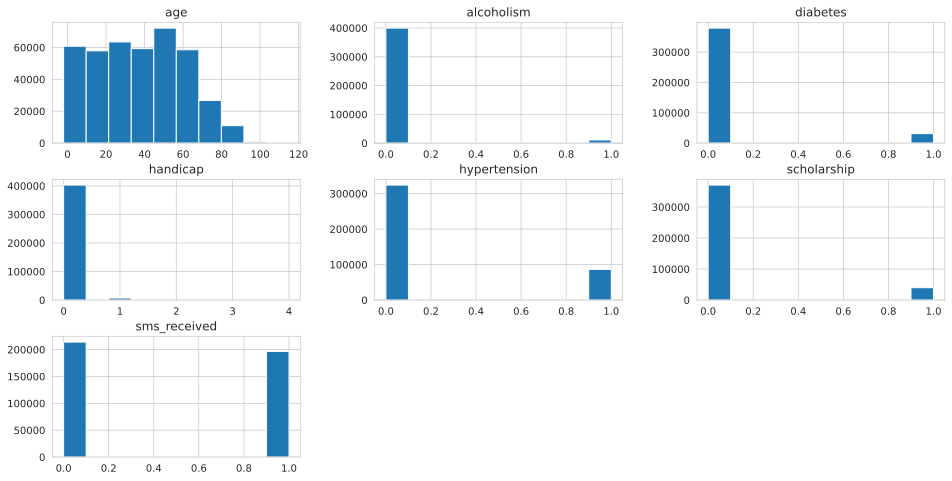

In [32]:
df.hist(figsize=(16,8));

**Observations so far**
1. **age:** Average age is around 37 years. But, age ranges between -2 and 115 years old and corrective action is needed as age cannot below less than 0 and there are very few old people. Need to investigate and take necessary action. 
2. **handicap:** Handicap has 4 values ranging from 0 to 4 and 75 percent of handicap have 0 value.
3. **sms_received:** Around 75% of patients have received sms reminder for their appointment.

Mapping independent 'no_show' variable

In [33]:
df.no_show.unique()

array(['noshow', 'showup'], dtype=object)

In [102]:
df['en_no_show'] = df['no_show'].map({'showup': 1, 'noshow': 0})
df.head(3)

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0,0


Unique values of no-show:  [0 1] 



[Text(0, 0.5, 'count'), Text(0.5, 0, 'no_show')]

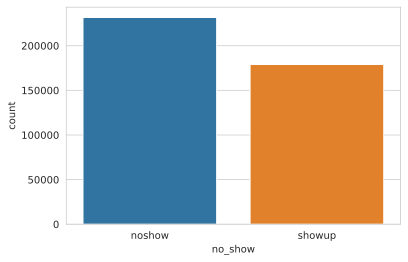

In [70]:
#checking unique value for no_show column
print('Unique values of no-show: ', df.en_no_show.unique(), '\n')
ax = sns.countplot(x='no_show', data =df)
ax.set(xlabel="no_show", ylabel = "count")

Updating Age values

Age range:  [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 108, 113, 115]


 Age Distribution


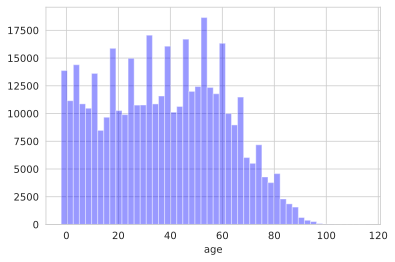

In [103]:
#checking uniques age values
print ("Age range: ", sorted(df['age'].unique()))


#Plotting graph for age 
print('\n\n Age Distribution')
sns.distplot(df['age'], hist=True, kde=False, color = 'blue')
plt.show()

Age values are between -2 to 115 years. As seen in the graph there are very few records above the age of 95 years. Updating the age range between 0 to 95 years.

In [104]:
# dropping -ve age and row above 95 years
df = df[(df.age >= 0) & (df.age <= 95)]

min_age = df['age'].min()
max_age = df['age'].max()
print ("Age now spans values from: {} to {}.".format(min_age, max_age))

Age now spans values from: 0 to 95.


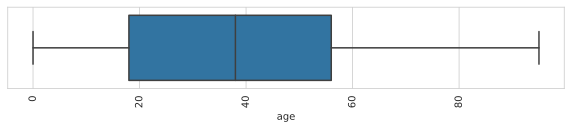

In [105]:
#Graoh for updated age  
plt.figure(figsize=(10,1.5))
plt.xticks(rotation=90)
sns.boxplot(x=df.age)

**What age ranges patient tend to have highest no show rate?**

Creating age bins to verfiy which age group is more likely to have no-show

In [106]:
#Creating bins for age groups 
age_ranges = [0, 12, 18, 25, 60, 75]
age_names = ["Children", "Teenager", 'Young-Adult', 'Adult', 'Senior']

df['age_bin'] = pd.cut(np.array(df['age']),bins=age_ranges, labels=age_names)
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show,age_bin
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0,0,Children
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0,0,Children
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0,0,Adult


In [107]:
#creating a freq table 
show_prob_age = pd.crosstab(df['age_bin'], df['no_show'], normalize='index')
show_prob_age

no_show,noshow,showup
age_bin,,
Children,0.532922,0.467078
Teenager,0.522491,0.477509
Young-Adult,0.520943,0.479057
Adult,0.568187,0.431813
Senior,0.616586,0.383414


From the above freq table, it can be observed that approx 62% of Senior who are above 60 years, 56% of Adults between 25-60 years of age and approx 52-53% of patient below 18 years of age are more likely to miss appointment and have a no-show.








**Is there any factor such as waiting time or other which have an impact on no-show?**

Starting with Converting dates format and calculating 'waiting_time', 'appointment_month' and 'hour_of_day'.


In [109]:
#Converting the schedule and appointment date from ISO8601 to standard format
df.schedule_day = df.schedule_day.apply(np.datetime64)
df.appointment_day = df.appointment_day.apply(np.datetime64)

print(df.schedule_day.head())
print(df.appointment_day.head())

0   2014-12-16 14:46:25
1   2015-08-18 07:01:26
2   2014-02-17 12:53:46
3   2014-07-23 17:02:11
4   2015-10-21 15:20:09
Name: schedule_day, dtype: datetime64[ns]
0   2015-01-14
1   2015-08-19
2   2014-02-18
3   2014-08-07
4   2015-10-27
Name: appointment_day, dtype: datetime64[ns]


In [110]:
#calculating waiting time 
appointment_waiting_time = df['appointment_day'] - df['schedule_day']
appointment_waiting_time = appointment_waiting_time.apply(lambda x: x.total_seconds() / (3600 * 24))

#adding column waiting_time and converting data type to int
df['waiting_time'] = appointment_waiting_time.round(0)
df['waiting_time'] = df['waiting_time'].astype(np.int64)
df.waiting_time.dtype

dtype('int64')

In [0]:
#Calculating appointment month
df['appointment_month'] = df['appointment_day'].apply(lambda x : dt.datetime.strftime(x, '%B'))

In [112]:
#encoding month to be used further
df['en_appointment_month'] = df['appointment_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 
                                                          'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show,age_bin,waiting_time,appointment_month,en_appointment_month
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,28,January,1
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,1,August,8
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,0,Children,0,February,2
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,0,Children,14,August,8
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,0,Adult,5,October,10


In [113]:
#Creating a function to calculate hours of appointment
def calculate_hour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:])
    return round(hour + minute/60 + second/3600)

df['hour_of_day'] = df.schedule_day.apply(calculate_hour)
df.head(5)

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show,age_bin,waiting_time,appointment_month,en_appointment_month,hour_of_day
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,28,January,1,15
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,1,August,8,7
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,0,Children,0,February,2,13
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,0,Children,14,August,8,17
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,0,Adult,5,October,10,15


Vizualizing for the data in each of the new columns and week_day

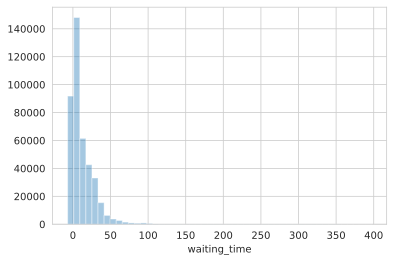

In [114]:
#Distribution for waiting_time
sns.distplot(df['waiting_time'], hist=True, kde=False)
plt.show()

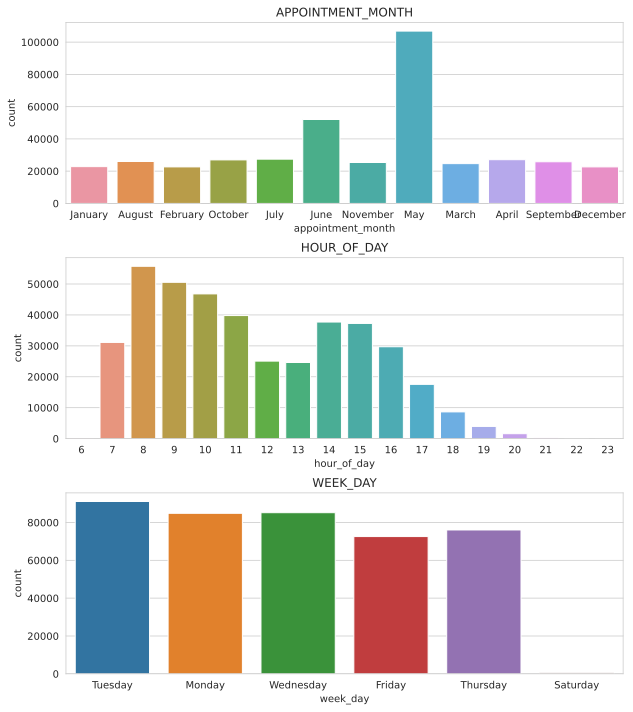

In [115]:
#plotting for other categorical variables
date_feild = ['appointment_month', 'hour_of_day', 'week_day']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
fig.subplots_adjust(hspace=0.3)

for ax, date_feild in zip(axes.flatten(), df[date_feild].columns):
    sns.countplot(x=date_feild, data=df, ax=ax)
    ax.set_title(date_feild.upper())

**Observations:**
1. **waiting_time:** it is observed that there are negative waiting_time which is incorrect also there are waiting time beyond 350 days. Need to investigate. 
2. **appointment_month:** May month seems to have the highest appoint scheduled. 
3. **hour_of_day:** most of the appointments are between 8 am to 11 am.
4. **week_day:** Tuesday has the highest appointments followed by Monday and Wednesday.

In [116]:
# removeing records waiting time < 0 and above 100 as there are only few patients 
df = df[(df.waiting_time >= 0) & (df.waiting_time <= 100)]

print('Minimum waiting time is:', df['waiting_time'].min())
print('Maximum waiting time is:', df['waiting_time'].max())

Minimum waiting time is: 0
Maximum waiting time is: 100


Calculating probability of feature with restpect to no-show

In [0]:
#Creating a fucntion to calculate probability of feature with respect to no_show
def probStatus(dataset, group_by):
    df = pd.crosstab(index = dataset[group_by], columns = dataset.no_show).reset_index()
    df['probShowUp'] = df['showup'] / (df['showup'] + df['noshow'])
    
    return df[[group_by, 'probShowUp']]

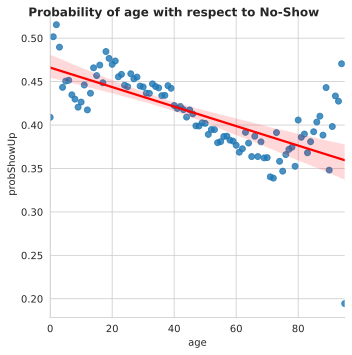

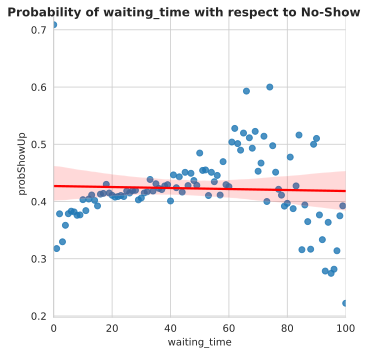

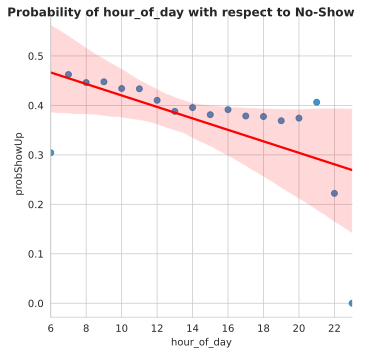

In [84]:
#checking for the below list of variables
col = ['age', 'waiting_time', 'hour_of_day']

for ax, var in zip(axes.flatten(), df[col].columns):
  lm = sns.lmplot(x = var, y = 'probShowUp', data = probStatus(df, var), fit_reg = True, line_kws={'color': 'red'})
  fig = lm.fig
  fig.suptitle(f'Probability of {var} with respect to No-Show \n\n\n ', fontsize=12, fontweight="bold")
  ax.set_title(var.upper())

In [125]:
#adding a variable for encoded week_day 
df['en_week_day'] = df['week_day'].astype('category')
df["en_week_day"] = df["en_week_day"].cat.codes
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show,age_bin,waiting_time,appointment_month,en_appointment_month,hour_of_day,en_week_day
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,28,January,1,15,4
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,1,August,8,7,4
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,0,Children,0,February,2,13,1
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,0,Children,14,August,8,17,5
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,0,Adult,5,October,10,15,5


**Checking if any gender tend to have highest no show rate**


In [117]:
#Checking relation between gender and no_show
gender_noshow = pd.crosstab(df['gender'], df['no_show'], normalize='index')
gender_noshow

no_show,noshow,showup
gender,,
F,0.584759,0.415241
M,0.569551,0.430449


**Checking if any disease tend to have highest no show rate**

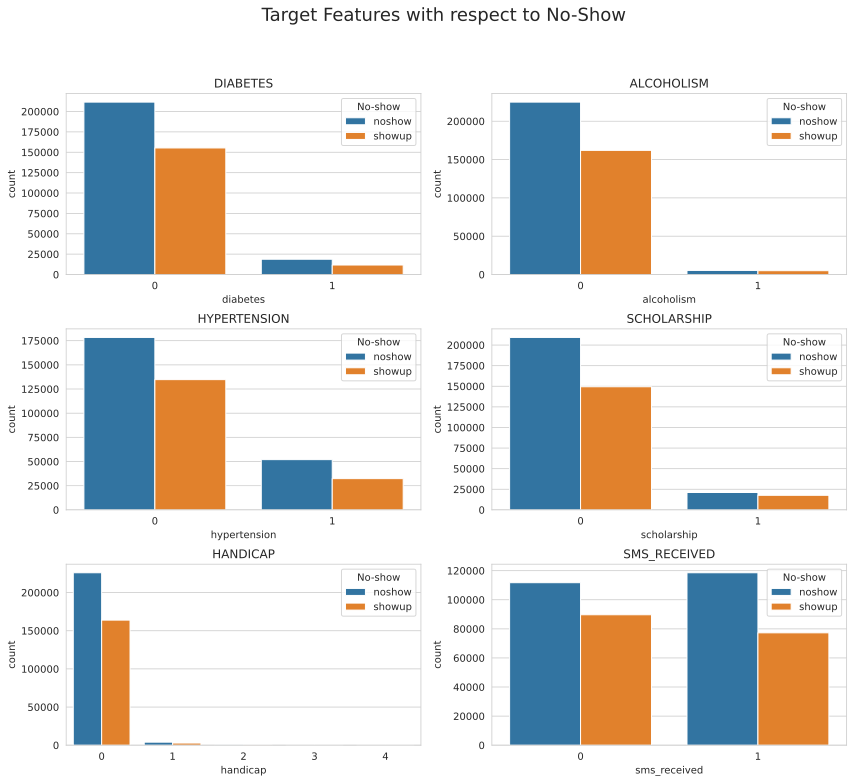

In [121]:
#Categorical features
binary_var = ['diabetes', 'alcoholism', 'hypertension', 'scholarship', 'handicap', 'sms_received' ]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,12))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Target Features with respect to No-Show', fontsize=18)

for ax, catplot in zip(axes.flatten(), df[binary_var].columns):
    sns.countplot(x=catplot, data=df, hue='no_show', ax=ax)
    ax.set_title(catplot.upper())
    ax.legend(title='No-show')

In [0]:
#To confirm the above result checking the pvalue

chi_test_var = ['age','gender', 'diabetes', 'alcoholism', 'hypertension', 'scholarship', 'handicap', 'sms_received', 'waiting_time','appointment_month', 'hour_of_day', 'week_day']
for column in (chi_test_var):
    chi2, p, dof,ex = chi2_contingency(pd.crosstab(index=df[column], columns=df["no_show"]), correction=False)
    print ('chi-squared test- p value for {} is: {r:6.5f}'. format(column,r = p))

chi-squared test- p value for age is: 0.00000
chi-squared test- p value for gender is: 0.00000
chi-squared test- p value for diabetes is: 0.00000
chi-squared test- p value for alcoholism is: 0.00000
chi-squared test- p value for hypertension is: 0.00000
chi-squared test- p value for scholarship is: 0.00000
chi-squared test- p value for handicap is: 0.32877
chi-squared test- p value for sms_received is: 0.00000
chi-squared test- p value for waiting_time is: 0.00000
chi-squared test- p value for appointment_month is: 0.00000
chi-squared test- p value for hour_of_day is: 0.00000
chi-squared test- p value for week_day is: 0.00000


In [0]:
#Converting Categprical Variable to numeric 

from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = preprocessing.LabelEncoder()
df['no_show'] = le.fit_transform(df['no_show'])

features = ['age', 'hypertension', 'diabetes', 'sms_received', 'waiting_time','appointment_month']

for variable in features: 
  le = preprocessing.LabelEncoder()
  df[variable] = le.fit_transform(df[variable])

In [0]:
df.corr(method='pearson')

,age,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,waiting_time,appointment_month,hour_of_day
age,1.000000,-0.019985,-0.060197,0.293957,0.076982,0.508052,0.077815,-0.104460,-0.039399,-0.005876,-0.003852,-0.006865
week_day,-0.019985,1.000000,0.011035,-0.006060,-0.003181,-0.007793,-0.001225,0.011228,-0.059064,-0.007427,0.009904,-0.000354
no_show,-0.060197,0.011035,1.000000,-0.021533,0.021114,-0.038864,-0.002634,0.023519,-0.051362,-0.011954,0.087340,-0.055549
diabetes,0.293957,-0.006060,-0.021533,1.000000,0.020580,0.426240,0.056184,-0.026614,-0.026914,-0.035053,-0.002000,-0.011289
alcoholism,0.076982,-0.003181,0.021114,0.020580,1.000000,0.074108,0.013312,0.039069,-0.020290,-0.030005,0.004118,-0.011923
hypertension,0.508052,-0.007793,-0.038864,0.426240,0.074108,1.000000,0.076058,-0.029879,-0.036351,-0.052992,-0.007469,-0.031455
handicap,0.077815,-0.001225,-0.002634,0.056184,0.013312,0.076058,1.000000,-0.004049,-0.022746,-0.014049,-0.000801,0.001226
scholarship,-0.104460,0.011228,0.023519,-0.026614,0.039069,-0.029879,-0.004049,1.000000,0.011358,-0.020631,0.003699,-0.017958
sms_received,-0.039399,-0.059064,-0.051362,-0.026914,-0.020290,-0.036351,-0.022746,0.011358,1.000000,0.285870,-0.097538,0.021606
waiting_time,-0.005876,-0.007427,-0.011954,-0.035053,-0.030005,-0.052992,-0.014049,-0.020631,0.285870,1.000000,-0.008304,0.029116


### Model Implementation



In [0]:
from sklearn.model_selection import train_test_split

#split data
X = df[features]
y = df['no_show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [0]:

print('Shape of X train data: ',X_train.shape)
print('Shape of X test data: ',X_test.shape)
print('Shape of X validation data: ',X_val.shape)
print('Shape of Y train data: ', y_train.shape)
print('Shape of Y test data: ', y_test.shape)
print('Shape of Y validation data: ',y_val.shape)

Shape of X train data:  (208665, 6)
Shape of X test data:  (119238, 6)
Shape of X validation data:  (69555, 6)
Shape of Y train data:  (208665,)
Shape of Y test data:  (119238,)
Shape of Y validation data:  (69555,)


### Logistic Regression

In [0]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

lr = LogisticRegression()

# Fit the model to the data
lr = lr.fit(X_train, y_train)

print ("Logistic Regression Model")
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

lr2 = lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(classification_report(y_test, lr.predict(X_test)))

Logistic Regression Model
Logistic Regression AUC = 0.51
              precision    recall  f1-score   support

           0       0.59      0.93      0.72     69230
           1       0.48      0.09      0.16     50008

    accuracy                           0.58    119238
   macro avg       0.53      0.51      0.44    119238
weighted avg       0.54      0.58      0.48    119238



In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

methods_data = {"Logistic Regression": (X_train, y_train)}

for method in methods_data.keys():
    #scoring=['roc_auc', 'accuracy']
    lr_results_acc = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], scoring='roc_auc')
    print(f"The best AUC Score for {method} data:")
    print (lr_results.mean())
    print("Accuracy: ", lr_results_acc.mean())

The best AUC Score for Logistic Regression data:
0.5666543489895497
Accuracy:  0.5756403805142214


### Random Forest Classifier

In [0]:
#Implementing Random Forest Classifier to predict no-show

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,accuracy_score,roc_auc_score

RFC = RandomForestClassifier(max_depth = 4, random_state = 60)
rf_parameter = {
        'n_estimators': 70, 
        'min_samples_leaf': 30
    }

# Fit the model to the data
RFC = RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

RFC_auc = accuracy_score(y_test, y_pred)

print ("RFC accuracy score = %2.2f" % RFC_auc)
print("RFC ROC score = %2.2f" % roc_auc_score(y_test, y_pred))


RFC accuracy score = 0.63
RFC ROC score = 0.57


### Gaussian Naive Bayes Classifier

In [0]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()

# Fit the model to the data
GNB = GNB.fit(X_train, y_train)

GNB_auc = accuracy_score(y_test, GNB.predict(X_test))

print ("Naive Bayes accuracy scoure= %2.2f" % GNB_auc)
print ("Naive Bayes ROC score= %2.2f" % roc_auc_score(y_test, GNB.predict(X_test)))

Naive Bayes accuracy scoure= 0.59
Naive Bayes ROC score= 0.57


### XGBoost Classifier

In [0]:
import xgboost as xgb

param_dist = {'objective':'binary:logistic', 'n_estimators':2}

xgm = xgb.XGBModel(**param_dist)

xgm.fit(X_train, y_train)

predict_train = xgm.predict(X_train)

In [0]:
from xgboost import XGBClassifier

# Create the Original training sets
methods_data = {"Original": (X_train, y_train)}

# Loop through training sets and apply 5-Fold CV using XGBoost Classifier
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='roc_auc')
    print(f"The best roc_auc Score for {method} data:")
    print (lr_results.mean())

The best roc_auc Score for Original data:
0.6980375430171049


In [0]:
#checking accuracy 
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    print(f"The best accuracy Score for {method} data:")
    print (lr_results.mean())

The best accuracy Score for Linear Regression data:
0.6644717609565571


In [0]:
#implementing GridSearchCV and XGBoost Classifier

from sklearn.model_selection import GridSearchCV

gbm_param_grid = {
'subsample': [0.9,1],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
  'learning_rate':[0.1,0.05],
 'n_estimators':[200,300]   
}

xgb_cl=XGBClassifier(objective= 'binary:logistic', nthread=6, tree_method='gpu_hist', eval_metric='auc',n_gpus=1,max_bin=16)

grid_mse = GridSearchCV(estimator=xgb_cl,param_grid=gbm_param_grid,scoring='roc_auc', cv=5, verbose=1,n_jobs=-1)
grid_mse.fit(X_train, y_train)
print("Best parameters found: ",grid_mse.best_params_)
print("Best ROC found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   23.4s finished


XGBoostError: ignored

In [0]:
#XGB=XGBClassifier(objective= 'binary:logistic', nthread=6, tree_method='gpu_hist', eval_metric='auc',n_gpus=1,max_bin=16,**grid_mse.best_params_)
#XGB = grid_mse.fit(X_train, y_train)

XGB_auc = roc_auc_score(y_test, grid_mse.predict(X_test))

print ("accuracy scoure= %2.2f" % XGB_auc)

XGBoostError: ignored

### Catboost

In [0]:
pip install catboost

     |████████████████████████████████| 64.4MB 54kB/s 


In [0]:
#implementing CatBoostClassfier

from catboost import CatBoostClassifier
for method in methods_data.keys():
    lr_results = cross_val_score(CatBoostClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    print(f"The best accuracy Score for {method} data:")
    print (lr_results.mean())

Streaming output truncated to the last 5000 lines.
7:	learn: 0.6307801	total: 508ms	remaining: 1m 3s
8:	learn: 0.6280697	total: 566ms	remaining: 1m 2s
9:	learn: 0.6256279	total: 619ms	remaining: 1m 1s
10:	learn: 0.6236127	total: 671ms	remaining: 1m
11:	learn: 0.6219207	total: 723ms	remaining: 59.6s
12:	learn: 0.6205886	total: 785ms	remaining: 59.6s
13:	learn: 0.6195072	total: 837ms	remaining: 59s
14:	learn: 0.6185793	total: 889ms	remaining: 58.4s
15:	learn: 0.6178369	total: 943ms	remaining: 58s
16:	learn: 0.6170877	total: 1s	remaining: 58.1s
17:	learn: 0.6165336	total: 1.06s	remaining: 57.7s
18:	learn: 0.6160531	total: 1.11s	remaining: 57.3s
19:	learn: 0.6154494	total: 1.16s	remaining: 57.1s
20:	learn: 0.6150055	total: 1.23s	remaining: 57.3s
21:	learn: 0.6145837	total: 1.28s	remaining: 57.1s
22:	learn: 0.6142457	total: 1.34s	remaining: 56.8s
23:	learn: 0.6139575	total: 1.39s	remaining: 56.5s
24:	learn: 0.6137381	total: 1.45s	remaining: 56.6s
25:	learn: 0.6135228	total: 1.5s	remaining: 

In [0]:
params = {'iterations':[50], 'depth':[3], 'learning_rate':[0.1]}
    
cb_clf = CatBoostClassifier()

grid_cb = GridSearchCV(estimator=cb_clf,param_grid=params,scoring='roc_auc', cv=5, verbose=1,n_jobs=-1)
grid_cb.fit(X_train, y_train)
print("Best parameters found: ",grid_cb.best_params_)
print("Best ROC found: ", np.sqrt(np.abs(grid_cb.best_score_)))
print("Best ROC for Test found: ", roc_auc_score(y_test, grid_cb.predict(X_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


0:	learn: 0.6815381	total: 40.1ms	remaining: 1.96s
1:	learn: 0.6721060	total: 76.8ms	remaining: 1.84s
2:	learn: 0.6644060	total: 109ms	remaining: 1.7s
3:	learn: 0.6580981	total: 140ms	remaining: 1.61s
4:	learn: 0.6529177	total: 172ms	remaining: 1.54s
5:	learn: 0.6486556	total: 203ms	remaining: 1.49s
6:	learn: 0.6451449	total: 250ms	remaining: 1.54s
7:	learn: 0.6416111	total: 285ms	remaining: 1.5s
8:	learn: 0.6387012	total: 320ms	remaining: 1.46s
9:	learn: 0.6367668	total: 351ms	remaining: 1.4s
10:	learn: 0.6349827	total: 382ms	remaining: 1.35s
11:	learn: 0.6332156	total: 414ms	remaining: 1.31s
12:	learn: 0.6312620	total: 452ms	remaining: 1.29s
13:	learn: 0.6302250	total: 485ms	remaining: 1.25s
14:	learn: 0.6287552	total: 517ms	remaining: 1.21s
15:	learn: 0.6279704	total: 552ms	remaining: 1.17s
16:	learn: 0.6269371	total: 585ms	remaining: 1.14s
17:	learn: 0.6258033	total: 619ms	remaining: 1.1s
18:	learn: 0.6249894	total: 661ms	remaining: 1.08s
19:	learn: 0.6243691	total: 703ms	remaining

## Feature Selection 

In [0]:
data = df

In [0]:
from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

encode_feature = data.drop(['no_show', 'appointment_day', 'schedule_day', 'handicap', 'age_bin', 'appointment_month'], axis=1)

for variable in encode_feature: 
  le = preprocessing.LabelEncoder()
  data[variable] = le.fit_transform(data[variable])

In [0]:
features = data.drop(['no_show', 'appointment_day', 'schedule_day', 'handicap', 'age_bin', 'appointment_month'], axis=1)
print(features.info())


labels = data['no_show']
print('\n no-show: ',labels.dtypes)

# Splitting dataset into train and test for features and labels
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=60,)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397458 entries, 0 to 410525
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   age           397458 non-null  int64
 1   gender        397458 non-null  int64
 2   week_day      397458 non-null  int64
 3   diabetes      397458 non-null  int64
 4   alcoholism    397458 non-null  int64
 5   hypertension  397458 non-null  int64
 6   scholarship   397458 non-null  int64
 7   sms_received  397458 non-null  int64
 8   waiting_time  397458 non-null  int64
 9   hour_of_day   397458 non-null  int64
dtypes: int64(10)
memory usage: 43.4 MB
None

 no-show:  int64


In [0]:
from sklearn import tree
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [0]:
# Setting up CV using stratifiedshufflesplit due to imbalance of no_show.

cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=60)

In [0]:
# Fitting a tree
clf = tree.DecisionTreeClassifier(random_state=60)
clf.fit(features_train, labels_train)

# Feature Importances to see whether new feature created has any importance.
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print ("Feature ranking: ")
for i in range(1, 10, 1):
    print ("  {}.  feature: {} ({})".format(i, features_train.columns[i], importances[indices[i]]))

Feature ranking: 
  1.  feature: gender (0.2216250768990164)
  2.  feature: week_day (0.21389623128584873)
  3.  feature: diabetes (0.11085487220322085)
  4.  feature: alcoholism (0.05572535147685445)
  5.  feature: hypertension (0.04684841018792999)
  6.  feature: scholarship (0.035681897853503605)
  7.  feature: sms_received (0.024525578866929965)
  8.  feature: waiting_time (0.021316893910676215)
  9.  feature: hour_of_day (0.005722053359173068)


In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=2)
selector.fit_transform(features_train, labels_train)


# Storing best features and their stores in separate pd.Series
scores = pd.Series(selector.scores_)
columns = pd.Series(features_train.columns)

# Concatenating both pd.Series into one df
selectbest = pd.concat([columns, scores], axis=1)
selectbest.rename(columns={0:'features', 1:'scores'}, inplace=True)

Text(0, 0.5, 'Score')

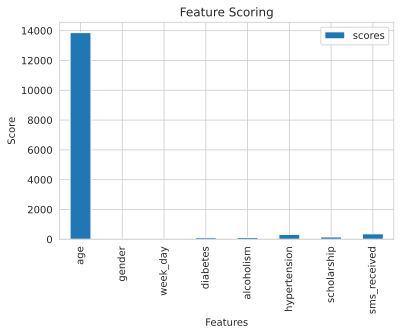

In [0]:
selectbest_plot = selectbest.iloc[:8,:].plot.bar()
selectbest_plot.set_title('Feature Scoring')
selectbest_plot.set_xticklabels(selectbest['features'])
selectbest_plot.set_xlabel('Features')
selectbest_plot.set_ylabel('Score')

In [0]:
# Top features based on different methods
best_chi_features = ['age', 'sms_received', 'hypertension']
best_features_importances = ['gender', 'week_day', 'diabetes',  'alcoholism','hypertension']
combined_best_features = ['age', 'sms_received','gender', 'week_day', 'diabetes',  'alcoholism','hypertension']

In [0]:
labels_test.value_counts()

0    69270
1    49968
Name: no_show, dtype: int64

In [0]:
print ("Patients who didn't show up: ", labels_test.mean())
print ("Patients who did show up: ", (1 - labels_test.mean()))

# Null Accuracy, ie. accuracy achieved by a dumb model if it only predicted a patient would show up to an appointment
print ("\n Null accuracy is therefore ", max(labels_test.mean(), 1 - labels_test.mean()))

Patients who didn't show up:  0.4190610375886882
Patients who did show up:  0.5809389624113118

 Null accuracy is therefore  0.5809389624113118


### Considering only top 3 features from feature selection

> Indented block



In [0]:
new_X = data.drop(['no_show', 'appointment_day', 'schedule_day', 'handicap', 'scholarship', 'age_bin', 'alcoholism',
             'waiting_time', 'appointment_month', 'hour_of_day', 'gender', 'week_day', 'diabetes'], axis=1)
new_X.info()


new_y = data['no_show']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397458 entries, 0 to 410525
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   age           397458 non-null  int64
 1   hypertension  397458 non-null  int64
 2   sms_received  397458 non-null  int64
dtypes: int64(3)
memory usage: 22.1 MB


In [0]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.3, random_state=60,)

#cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=60)

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200)
model = classifier.fit(new_X_train, new_y_train)
y_pred = model.predict(new_X_test)

In [0]:
print(metrics.accuracy_score(new_y_train, model.predict(new_X_train)))
print(metrics.accuracy_score(new_y_test, y_pred))

0.5816763712170225
0.5837065365068183


In [0]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19877 sha256=36049200d1e92ad1011d5f8b6a5b65b36324e5170bd0d43f4fb603bab56d0ed3
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [0]:
from xgboost import XGBClassifier
from vecstack import stacking

models=[KNeighborsClassifier(), RandomForestClassifier()]
S_train, S_test = stacking(models, X_train, y_train, X_test, regression = False, 
                           mode = 'oof_pred_bag', 
                           needs_proba = False, 
                           save_dir = None, 
                           metric = accuracy_score, 
                           n_folds = 4, 
                           stratified = True, 
                           shuffle = True, 
                           random_state = 0, 
                           verbose =2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.61435390]
    fold  1:  [0.61202699]
    fold  2:  [0.61371391]
    fold  3:  [0.61501744]
    ----
    MEAN:     [0.61377806] + [0.00111108]
    FULL:     [0.61377807]

model  1:     [RandomForestClassifier]
    fold  0:  [0.61506316]
    fold  1:  [0.61405897]
    fold  2:  [0.61522831]
    fold  3:  [0.61308132]
    ----
    MEAN:     [0.61435794] + [0.00086227]
    FULL:     [0.61435794]



Trying XG boost again

In [0]:
import xgboost as xgb

param_dist = {'objective':'binary:logistic', 'n_estimators':2}

new_xgm = xgb.XGBModel(**param_dist)

new_xgm.fit(new_X_train, new_y_train)

new_predict_train = xgm.predict(new_X_train)

ValueError: ignored

In [0]:
from xgboost import XGBClassifier

# Create the Original training sets
methods_data = {"Original": (X_train, y_train)}

# Loop through training sets and apply 5-Fold CV using XGBoost Classifier
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='roc_auc')
    print(f"The best roc_auc Score for {method} data:")
    print (lr_results.mean())

In [0]:
from xgboost import XGBClassifier

# Create the Original training sets
methods_data = {"Original": (X_train, y_train)}

# Loop through training sets and apply 5-Fold CV using XGBoost Classifier
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='roc_auc')
    print(f"The best roc_auc Score for {method} data:")
    print (lr_results.mean())

In [0]:
#checking accuracy 
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    print(f"The best accuracy Score for {method} data:")
    print (lr_results.mean())

In [0]:
#implementing GridSearchCV and XGBoost Classifier

from sklearn.model_selection import GridSearchCV

gbm_param_grid = {
'subsample': [0.9,1],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
  'learning_rate':[0.1,0.05],
 'n_estimators':[200,300]   
}

xgb_cl=XGBClassifier(objective= 'binary:logistic', nthread=6, tree_method='gpu_hist', eval_metric='auc',n_gpus=1,max_bin=16)

grid_mse = GridSearchCV(estimator=xgb_cl,param_grid=gbm_param_grid,scoring='roc_auc', cv=5, verbose=1,n_jobs=-1)
grid_mse.fit(X_train, y_train)
print("Best parameters found: ",grid_mse.best_params_)
print("Best ROC found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [0]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras import optimizers, metrics

In [0]:
# Now we build the Keras model
model = Sequential()
#model = models.Sequential()
model.add(Dense(25, activation='relu', input_shape=(11,)))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
rms=optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
len(features_train.columns)

10

In [0]:
# Train the model
history = model.fit(features_train,labels_train,epochs=25,batch_size=100,validation_split=0.3)

Epoch 1/25


ValueError: ignored

In [0]:
loss, accuracy  = model.evaluate(features_test, labels_test, verbose=False)

ValueError: ignored

In [0]:
  print(f'Test loss : {loss:.5}')
  print(f'Test accuracy : {accuracy:.5}')